In [2]:
import os 
import math
import scipy
import librosa
from librosa import load, display
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from tones import SINE_WAVE
from tones.mixer import Mixer 

from tqdm import tqdm
from scipy.io import wavfile
from scipy import signal as signal
from skimage.measure import block_reduce

import plot as pl 
import settings as sett
from functions.Sample import Sound

plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['figure.dpi'] 

72.0

In [3]:
tonotopic_maps = np.load(os.path.join('../Data/INT_Sebmice_alignedtohorizon.npy'))

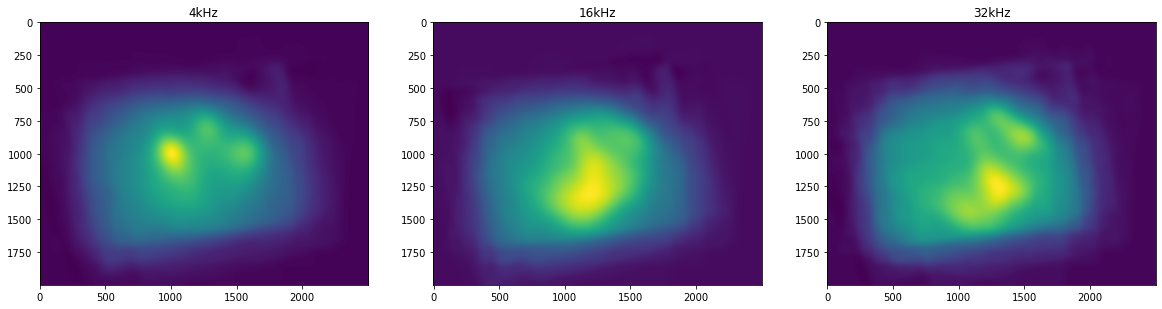

In [4]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(1 - tonotopic_maps[1])
axs[1].imshow(1 - tonotopic_maps[2])
axs[2].imshow(1 - tonotopic_maps[3])

axs[0].set_title('4kHz')
axs[1].set_title('16kHz')
axs[2].set_title('32kHz')

plt.show()

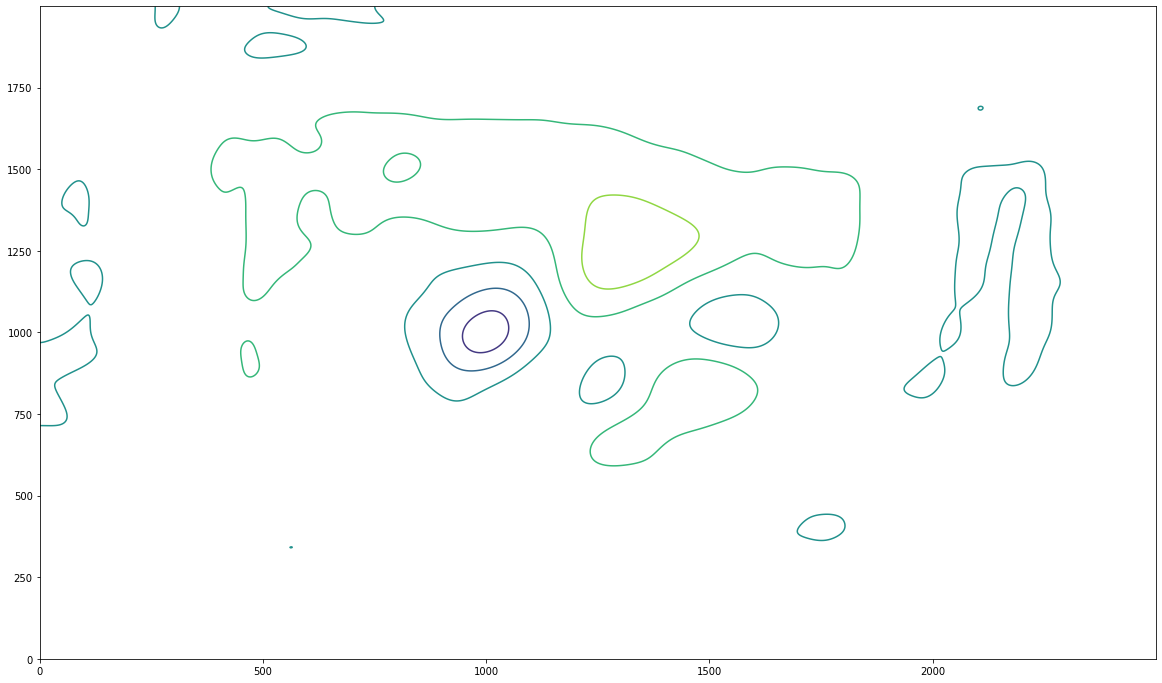

In [6]:
tmap4 = tonotopic_maps[1]
tmap32 = tonotopic_maps[3]

# Normalize tmaps
tmap4 = 1 - (tmap4 - np.min(tmap4)) / (np.max(tmap4) - np.min(tmap4))
tmap32 = 1 - (tmap32 - np.min(tmap32)) / (np.max(tmap32) - np.min(tmap32))

plt.contour(tmap32 - tmap4)

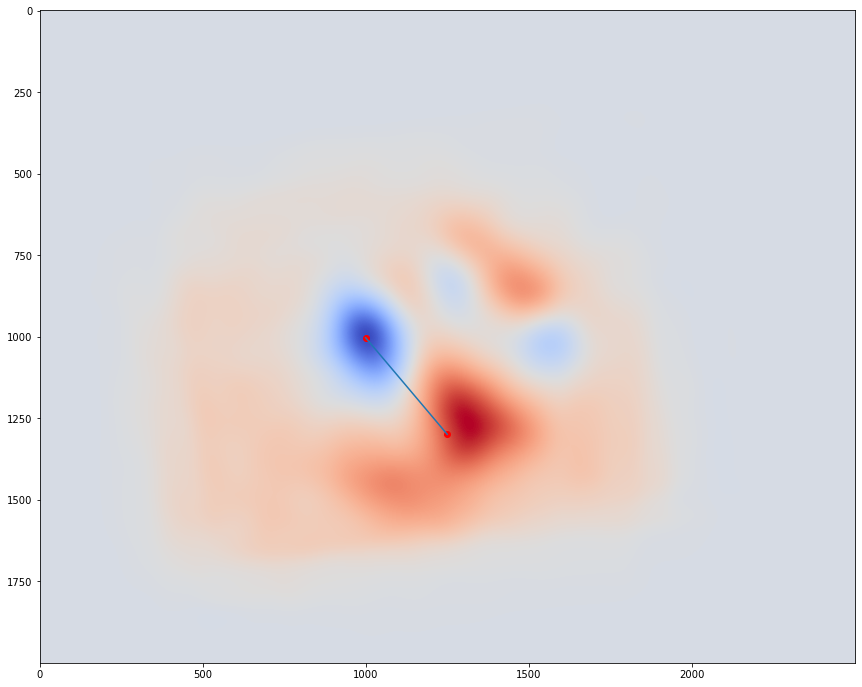

In [147]:
tmap4 = tonotopic_maps[1]
tmap32 = tonotopic_maps[3]

# Normalize tmaps
tmap4 = 1 - (tmap4 - np.min(tmap4)) / (np.max(tmap4) - np.min(tmap4))
tmap32 = 1 - (tmap32 - np.min(tmap32)) / (np.max(tmap32) - np.min(tmap32))

min4 = np.unravel_index(tmap4.argmax(), tmap4.shape)
min32 = np.unravel_index(tmap32.argmax(), tmap32.shape)

tmap4 = tmap4**2
tmap32 = tmap32**2

#tmap4[tmap4 <=0.7] = 0
#tmap32[tmap32 <=0.8] = 0


# 4kHz is negative, 32 positive

weighted_tmap = tmap32 - tmap4


plt.imshow(weighted_tmap, cmap='coolwarm')
plt.scatter(min4[0], min4[1], marker='o', c='red')
plt.scatter(min32[0], min32[1], marker='o', c='red')
plt.plot([min4[0], min32[0]], [min4[1], min32[1]])

plt.show()

[250 296]


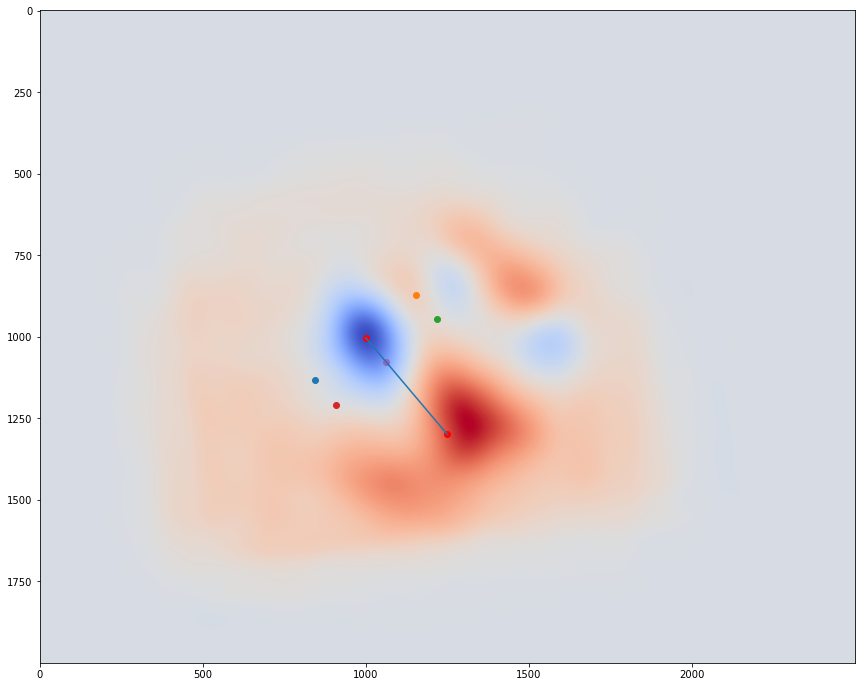

In [148]:
# Get distance between two minimum
distance_min = math.sqrt((min4[0] - min32[0])**2 + (min4[1] - min32[1])**2)

# Define number of bins
bins = 4
dist_bin = distance_min / bins
vector = np.array([min32[0] - min4[0], min32[1] - min4[1]])
vector_bin = vector * 1/bins

# Get limit of rectangle
x0 = np.floor(min4[0] + int(vector_bin[0])) 
y0 = np.floor(min4[1] + int(vector_bin[1])) 

# Get sides


print(vector)
width_rect = 0.4*distance_min

# Draw rectangle
rect = []
rect.append([min4[0] - width_rect, min4[1] + width_rect*vector[0]/vector[1]])
rect.append([min4[0] + width_rect, min4[1] - width_rect*vector[0]/vector[1]])
rect.append([min4[0] + width_rect + vector_bin[0], min4[1] + vector_bin[1] - width_rect*vector[0]/vector[1]])
rect.append([min4[0] - width_rect + vector_bin[0], min4[1] + vector_bin[1] + width_rect*vector[0]/vector[1]])
rect = np.array(rect)


plt.scatter(min4[0] - width_rect, min4[1] + width_rect*vector[0]/vector[1])
plt.scatter(min4[0] + width_rect, min4[1] - width_rect*vector[0]/vector[1])
plt.scatter(min4[0] + width_rect + vector_bin[0], min4[1] + vector_bin[1] - width_rect*vector[0]/vector[1])
plt.scatter(min4[0] - width_rect + vector_bin[0], min4[1] + vector_bin[1] + width_rect*vector[0]/vector[1])



#  To check if poitn inside a rectangle, calculate areas of the triangles. 
# Otherwise find a way to directly select all points

plt.scatter(x0, y0)
plt.imshow(weighted_tmap, cmap='coolwarm')
plt.scatter(min4[0], min4[1], marker='o', c='red')
plt.scatter(min32[0], min32[1], marker='o', c='red')
plt.plot([min4[0], min32[0]], [min4[1], min32[1]])

plt.show()
plt.close()

In [151]:
# Get all points inside a rectangle
def get_equation(point1, point2):
    a = (point2[1] - point1[1])/(point2[0] - point1[0])
    b = point1[1] - a * point1[0]
    return a, b
    
a, b = get_equation(rect[0, :], rect[1, :])
print(rect[:, 0], rect[:, 1])

x = np.linspace(1, weighted_tmap.shape[1], 100)
y = a * x + b
plt.plot(x, y)

idx_x = np.arange(int(np.min(rect[:, 0])), int(np.max(rect[:, 0])), 1)
idx_y = np.arange(int(np.min(rect[:, 1])), int(np.max(rect[:, 1])), 1)
print(np.min(idx_x), np.max(idx_x))

corner1 = rect[0]
corner2 = rect[1]

inside = []
edges = np.array([[rect[0], rect[1]],
                  [rect[1], rect[2]],
                  [rect[2], rect[3]],
                  [rect[3], rect[0]]])

for edge in edges:
    corner1 = edge[0]
    corner2 = edge[1]
    for idy in idx_y:
        for idx in idx_x:
            if idy >  a * idx + b:
                inside.append([int(idx), int(idy)])

inside = np.array(inside)

weighted_tmap = weighted_tmap[inside[:, 0], inside[:, 1]]


# Script for checking
plt.imshow(weighted_tmap, cmap='coolwarm')
plt.scatter(rect[:,0], rect[:,1])
plt.scatter(min4[0], min4[1], marker='o', c='red')
plt.scatter(min32[0], min32[1], marker='o', c='red')
plt.plot([min4[0], min32[0]], [min4[1], min32[1]])
plt.show()

[ 844.02077559 1153.97922441 1216.47922441  906.52077559] [1133.89461521  872.10538479  946.10538479 1207.89461521]


IndexError: tuple index out of range